In [ ]:
import os
import numpy as np
import scipy.stats as scs
import pickle
import joblib
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from Ratio import *
from Ratio_L_and_W import *

start = time.time()

# load sims_runs_all from a pkl file
with open('simulated_data_25_runs_4copulas_2Dexperiment.pkl', 'rb') as f:
    sims_runs_all = pickle.load(f)

np.random.seed(990109)
torch.manual_seed(990109)

N_TRAIN = 5000
N_TEST = 5000


# Create a directory to save the model parameters
os.makedirs('model_parameters_W_ratio_25_runs_4copulas_2Dexperiment', exist_ok=True)

# Fit W_ratio on all examples

W_L_ratios_all = []
W_L_ratios_ll = []
for r,run in (enumerate(sims_runs_all)):
    # run = [u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]
    for u,u1_u2 in enumerate(run):
        if r<3 :
            continue
        # u1_u2 = [u1, u2]
        z1,z2 = scs.norm.ppf(u1_u2[0][:N_TRAIN]),scs.norm.ppf(u1_u2[1][:N_TRAIN])
        p_data = np.column_stack((z1,z2))
        p_data = np.nan_to_num(p_data, nan=0, posinf=0, neginf=0)
        # Fit Ratio copula
        ratio = W_Ratio_fit(z_cop=p_data,waymarks=10,return_waymark_datasets=False, q_indep_sample_nb= 10*p_data.shape[0]*p_data.shape[1])
        # Compute log-likelihood
        z1_test,z2_test = scs.norm.ppf(u1_u2[0][N_TRAIN:]),scs.norm.ppf(u1_u2[1][N_TRAIN:])
        p_data_test = np.column_stack((z1_test,z2_test))
        p_data_test = np.nan_to_num(p_data_test, nan=0, posinf=6., neginf=-6.)
        W_L_ratios_ll.append(W_ratio_compute(ratio, p_data_test,log_pdf=True).sum())
        print('run',r,'cop_u',u,'DONE',' |||| Time so far:', time.time()-start)
        W_L_ratios_all.append(ratio)

        # Save the model parameters
        model_path = f'model_parameters_W_ratio_25_runs_4copulas_2Dexperiment/NNet_ratio_run_{r}_cop_u_{u}.pt'
        torch.save([r.state_dict() for r in ratio], model_path)

# save W_L_ratios_ll as a pkl file
with open('W_ratios_ll_25_runs_4copulas_2Dexperiment.pkl', 'wb') as f:
    pickle.dump(W_L_ratios_ll, f)

print('Time taken:', time.time()-start)

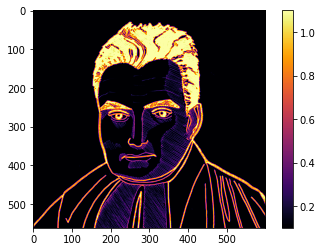

In [157]:
import os
import numpy as np
import scipy.stats as scs
import pickle
import joblib
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from Ratio import *
from Ratio_L_and_W import *

start = time.time()

import matplotlib.image as mpimg

img=mpimg.imread('../bayes_image.png')#'emily1.jpg')#
# convert to grayscale
img = np.mean(img, axis=2)
img = np.log(1e-2 +img / 6.0)
# rescale to 0,1
img = (img - np.min(img)) / (np.max(img) - np.min(img))
img = np.abs(img - 1.0) +0.1
#img = img[:400,:450]
plt.imshow(img, cmap='inferno')
plt.colorbar()

np.random.seed(990109)
torch.manual_seed(990109)

N_TRAIN = 5000
N_TEST = 5000

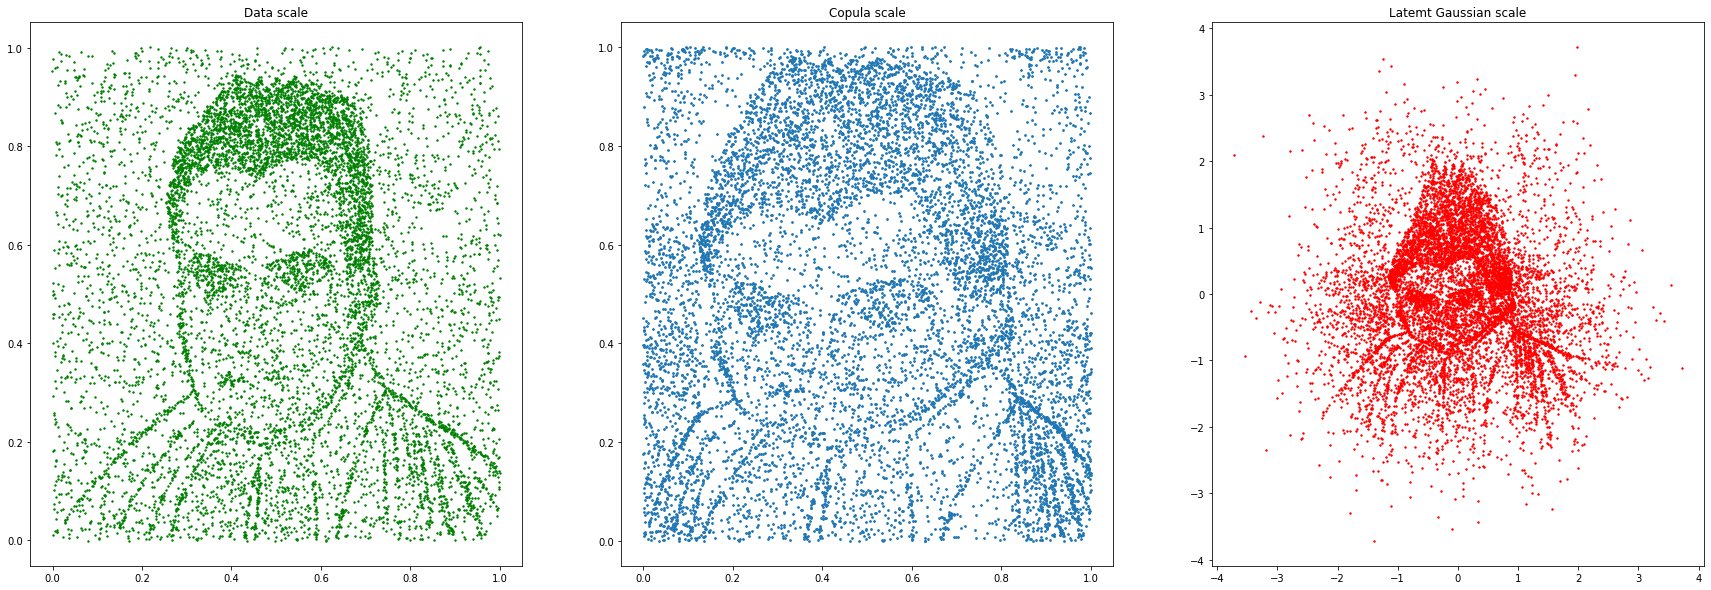

In [158]:
img_probs = img/ np.sum(img)
sample_idx = np.random.choice(np.arange(img_probs.flatten().shape[0]), size=10000,  p=img_probs.flatten())
x = np.linspace(0, 1, img.shape[1])
y = np.linspace(1, 0, img.shape[0])
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()
X = X[sample_idx]
Y = Y[sample_idx]
data_p = np.stack([X, Y], axis=1) + np.random.normal(0, 0.001, (X.shape[0], 2))

from statsmodels.distributions.empirical_distribution import ECDF

cdf_1 = ECDF(data_p[:,0])
cdf_2 = ECDF(data_p[:,1])

from scipy.interpolate import interp1d
import scipy 

slope_changes = sorted(set(data_p[:,0]))

sample_edf_values_at_slope_changes1 = [ cdf_1(item) for item in slope_changes]
sample_edf_values_at_slope_changes2 = [ cdf_2(item) for item in slope_changes]

# Extend the range of the input values by 0.1
extended_sample_edf_values1 = np.concatenate(([sample_edf_values_at_slope_changes1[0] - 0.1], sample_edf_values_at_slope_changes1, [sample_edf_values_at_slope_changes1[-1] + 0.1]))
extended_sample_edf_values2 = np.concatenate(([sample_edf_values_at_slope_changes2[0] - 0.1], sample_edf_values_at_slope_changes2, [sample_edf_values_at_slope_changes2[-1] + 0.1]))
extended_slope_changes = np.concatenate(([slope_changes[0] - 0.1], slope_changes, [slope_changes[-1] + 0.1]))

# Create the interpolating functions with extrapolation
inverted_cdf1 = interp1d(extended_sample_edf_values1, extended_slope_changes, bounds_error=False, fill_value="extrapolate")
inverted_cdf2 = interp1d(extended_sample_edf_values2, extended_slope_changes, bounds_error=False, fill_value="extrapolate")

u = cdf_1(data_p[:,0])
v = cdf_2(data_p[:,1])

z1 = scipy.stats.norm.ppf(u)
z2 = scipy.stats.norm.ppf(v)
z = np.stack([z1, z2], axis=1)

# do a 3 subplot
fig, ax = plt.subplots(1,3, figsize=(30,10))
ax[0].scatter(data_p[:,0],data_p[:,1],s=2,c='green')
ax[1].scatter(u,v, s=3)
ax[2].scatter(z1,z2, s=2, c='red')
# titles for each
ax[0].set_title('Data scale')
ax[1].set_title('Copula scale')
ax[2].set_title('Latemt Gaussian scale')

plt.show()

# Simple NNEt

In [167]:
# train ratio copula
from Ratio import Ratio
from Ratio import loss_nce
from tqdm import tqdm

u1, u2 = u,v

q_data = np.random.randn(5000,2)
ratio = Ratio(h_dim=100, in_dim=2, h_layers=5)

optimizer = torch.optim.Adam(ratio.parameters(), lr= 0.002)
z[z==np.inf] = 0


for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    r_p = ratio(tt(z[np.random.choice(range(z.shape[0]),size=5000)]).float())
    r_q = ratio(tt(np.random.randn(5000,2)).float())
    #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
    loss = loss_nce(r_p, r_q, 5000, 5000)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            print(f'Epoch {epoch}, loss {loss.item()}')

model = ratio

  0%|          | 2/10000 [00:00<19:06,  8.72it/s]

Epoch 0, loss 1.837472915649414


  1%|          | 102/10000 [00:12<19:23,  8.51it/s]

Epoch 100, loss 1.3488996028900146


  2%|▏         | 202/10000 [00:26<21:19,  7.66it/s]

Epoch 200, loss 1.3346980810165405


  3%|▎         | 302/10000 [00:39<19:11,  8.42it/s]

Epoch 300, loss 1.3246574401855469


  4%|▍         | 402/10000 [00:53<21:21,  7.49it/s]

Epoch 400, loss 1.317872405052185


  5%|▌         | 502/10000 [01:05<19:17,  8.21it/s]

Epoch 500, loss 1.3247804641723633


  6%|▌         | 602/10000 [01:18<19:38,  7.97it/s]

Epoch 600, loss 1.3055719137191772


  7%|▋         | 702/10000 [01:31<18:40,  8.30it/s]

Epoch 700, loss 1.3096847534179688


  8%|▊         | 802/10000 [01:44<23:51,  6.42it/s]

Epoch 800, loss 1.307999610900879


  9%|▉         | 902/10000 [01:58<20:51,  7.27it/s]

Epoch 900, loss 1.3197360038757324


 10%|█         | 1002/10000 [02:11<18:47,  7.98it/s]

Epoch 1000, loss 1.3037488460540771


 11%|█         | 1102/10000 [02:24<19:21,  7.66it/s]

Epoch 1100, loss 1.30122971534729


 12%|█▏        | 1202/10000 [02:38<18:35,  7.88it/s]

Epoch 1200, loss 1.311847448348999


 13%|█▎        | 1302/10000 [02:51<19:15,  7.53it/s]

Epoch 1300, loss 1.3006603717803955


 14%|█▍        | 1402/10000 [03:05<18:23,  7.79it/s]

Epoch 1400, loss 1.296229362487793


 15%|█▌        | 1502/10000 [03:18<17:41,  8.00it/s]

Epoch 1500, loss 1.3018798828125


 16%|█▌        | 1602/10000 [03:31<19:56,  7.02it/s]

Epoch 1600, loss 1.2966521978378296


 17%|█▋        | 1702/10000 [03:45<19:49,  6.98it/s]

Epoch 1700, loss 1.2975709438323975


 18%|█▊        | 1802/10000 [03:57<16:06,  8.48it/s]

Epoch 1800, loss 1.2847504615783691


 19%|█▉        | 1902/10000 [04:10<17:08,  7.87it/s]

Epoch 1900, loss 1.2990751266479492


 20%|██        | 2002/10000 [04:23<18:03,  7.38it/s]

Epoch 2000, loss 1.2972424030303955


 21%|██        | 2102/10000 [04:37<15:25,  8.54it/s]

Epoch 2100, loss 1.292109489440918


 22%|██▏       | 2202/10000 [04:51<25:42,  5.06it/s]

Epoch 2200, loss 1.2921637296676636


 23%|██▎       | 2302/10000 [05:04<16:24,  7.82it/s]

Epoch 2300, loss 1.3008673191070557


 24%|██▍       | 2402/10000 [05:17<16:43,  7.57it/s]

Epoch 2400, loss 1.2973804473876953


 25%|██▌       | 2502/10000 [05:30<17:43,  7.05it/s]

Epoch 2500, loss 1.2944892644882202


 26%|██▌       | 2602/10000 [05:43<14:21,  8.59it/s]

Epoch 2600, loss 1.2865458726882935


 27%|██▋       | 2702/10000 [05:55<14:18,  8.50it/s]

Epoch 2700, loss 1.2948371171951294


 28%|██▊       | 2802/10000 [06:08<13:35,  8.83it/s]

Epoch 2800, loss 1.2809324264526367


 29%|██▉       | 2902/10000 [06:21<18:33,  6.38it/s]

Epoch 2900, loss 1.295423984527588


 30%|███       | 3002/10000 [06:35<17:42,  6.58it/s]

Epoch 3000, loss 1.2956771850585938


 31%|███       | 3102/10000 [06:48<14:01,  8.20it/s]

Epoch 3100, loss 1.2923402786254883


 32%|███▏      | 3202/10000 [07:02<13:26,  8.43it/s]

Epoch 3200, loss 1.2851247787475586


 33%|███▎      | 3302/10000 [07:16<15:07,  7.38it/s]

Epoch 3300, loss 1.2913172245025635


 34%|███▍      | 3402/10000 [07:29<13:51,  7.93it/s]

Epoch 3400, loss 1.2887039184570312


 35%|███▌      | 3502/10000 [07:42<13:51,  7.81it/s]

Epoch 3500, loss 1.2819936275482178


 36%|███▌      | 3602/10000 [07:56<16:26,  6.48it/s]

Epoch 3600, loss 1.2837507724761963


 37%|███▋      | 3702/10000 [08:08<12:17,  8.53it/s]

Epoch 3700, loss 1.2822473049163818


 38%|███▊      | 3802/10000 [08:21<12:02,  8.58it/s]

Epoch 3800, loss 1.282938003540039


 39%|███▉      | 3902/10000 [08:34<15:09,  6.71it/s]

Epoch 3900, loss 1.2885160446166992


 40%|████      | 4002/10000 [08:47<12:22,  8.07it/s]

Epoch 4000, loss 1.2804079055786133


 41%|████      | 4102/10000 [09:00<13:29,  7.29it/s]

Epoch 4100, loss 1.2851288318634033


 42%|████▏     | 4202/10000 [09:14<13:11,  7.32it/s]

Epoch 4200, loss 1.287114143371582


 43%|████▎     | 4302/10000 [09:27<14:12,  6.69it/s]

Epoch 4300, loss 1.2783565521240234


 44%|████▍     | 4402/10000 [09:40<11:08,  8.37it/s]

Epoch 4400, loss 1.2810384035110474


 45%|████▌     | 4502/10000 [09:54<14:40,  6.25it/s]

Epoch 4500, loss 1.2748801708221436


 46%|████▌     | 4602/10000 [10:07<12:07,  7.42it/s]

Epoch 4600, loss 1.294694185256958


 47%|████▋     | 4702/10000 [10:19<10:38,  8.30it/s]

Epoch 4700, loss 1.2811250686645508


 48%|████▊     | 4802/10000 [10:32<11:47,  7.35it/s]

Epoch 4800, loss 1.2800952196121216


 49%|████▉     | 4902/10000 [10:44<09:41,  8.77it/s]

Epoch 4900, loss 1.2836872339248657


 50%|█████     | 5002/10000 [10:57<10:10,  8.19it/s]

Epoch 5000, loss 1.2786140441894531


 51%|█████     | 5102/10000 [11:10<12:22,  6.60it/s]

Epoch 5100, loss 1.2868733406066895


 52%|█████▏    | 5202/10000 [11:24<10:12,  7.84it/s]

Epoch 5200, loss 1.2790584564208984


 53%|█████▎    | 5302/10000 [11:37<09:21,  8.37it/s]

Epoch 5300, loss 1.2822785377502441


 54%|█████▍    | 5402/10000 [11:50<09:21,  8.19it/s]

Epoch 5400, loss 1.278660535812378


 55%|█████▌    | 5502/10000 [12:03<09:46,  7.67it/s]

Epoch 5500, loss 1.288144588470459


 56%|█████▌    | 5602/10000 [12:17<09:14,  7.93it/s]

Epoch 5600, loss 1.2845371961593628


 57%|█████▋    | 5702/10000 [12:31<09:14,  7.75it/s]

Epoch 5700, loss 1.282999038696289


 57%|█████▋    | 5729/10000 [12:35<10:40,  6.67it/s]

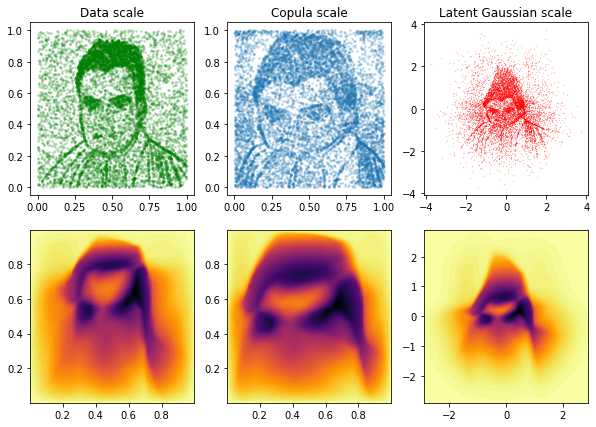

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

meshgrid = np.meshgrid(np.linspace(-2.9,2.9,100), np.linspace(-2.9,2.9,100))

ratio_grid = model(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).detach().numpy() # 1000x1000
gauss = torch.distributions.MultivariateNormal(tt([0.,0.]), tt([[1.,0.],[0.,1.]])).log_prob(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).exp().reshape(-1,1).detach().numpy()
    
ratio_grid = np.clip(ratio_grid, a_min=0.01, a_max=1.5)
# Adjust the subplot configuration to 2 rows by 3 columns
fig, ax = plt.subplots(2, 3, figsize=(10, 7))  # Adjusted for 6 plots

# Original scatter plots

ax[0, 0].scatter(data_p[:,0], data_p[:,1], s=3, c='green', alpha=0.2)
ax[0, 1].scatter(u, v, s=3, alpha=0.2)
#ax[0, 2].scatter(scs.norm.rvs(size=10000), scs.norm.rvs(size=10000), s=1, c='black')
ax[0, 2].scatter(z1, z2, s=0.01, c='red')

# Titles for each scatter plot
ax[0, 0].set_title('Data scale')
ax[0, 1].set_title('Copula scale')
ax[0, 2].set_title('Latent Gaussian scale')

# Original contour plots with colorbars
in_1 = np.clip(scs.norm.cdf(meshgrid[0]),a_max=0.999,a_min=0.001)
in_2 = np.clip(scs.norm.cdf(meshgrid[1]),a_max=0.999,a_min=0.001)

contour_set = ax[1, 0].contourf(inverted_cdf1(in_1),inverted_cdf2(in_2), (gauss* ratio_grid).reshape(100, 100),levels=100,cmap='inferno_r')
contour_set = ax[1, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), (gauss*ratio_grid).reshape(100, 100),levels=100,cmap='inferno_r')
contour_set = ax[1, 2].contourf(meshgrid[0], meshgrid[1], (gauss*ratio_grid).reshape(100, 100),levels=100,cmap='inferno_r')


# TRE

In [141]:
# Fit W_ratio on all examples

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


# u1_u2 = [u1, u2]
p_data = z
p_data = np.nan_to_num(p_data, nan=0, posinf=0, neginf=0)
# Fit Ratio copula
ratio = W_Ratio_fit(z_cop=p_data,waymarks=4,return_waymark_datasets=False)

# Save the model parameters
#model_path = f'model_parameters_W_ratio_25_runs_4copulas_2Dexperiment/NNet_ratio_run_{r}_cop_u_{u}.pt'
#torch.save([r.state_dict() for r in ratio], model_path)


KeyboardInterrupt: 

In [146]:
# Load the state dictionaries into the model instances
state_dicts = torch.load('NNet_ratio_cop_im_10Ks_10W_2Ke.pt')

for r, state_dict in zip(ratio, state_dicts):
    r.load_state_dict(state_dict)

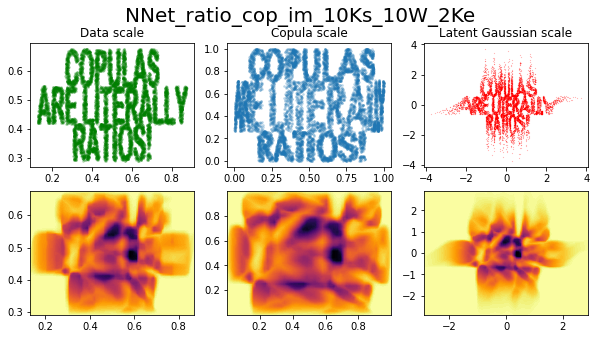

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
from torch import tensor as tt

meshgrid = np.meshgrid(np.linspace(-2.9,2.9,100), np.linspace(-2.9,2.9,100))

ratio_grid = W_ratio_compute(ratio,(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).detach().numpy() )# 1000x1000
ratio_grid = ratio_grid.detach().numpy()
gauss = torch.distributions.MultivariateNormal(tt([0.,0.]), tt([[1.,0.],[0.,1.]])).log_prob(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).exp().reshape(-1,1).detach().numpy()
    
ratio_grid = np.clip(ratio_grid, a_min=0.01, a_max=1.5)
# Adjust the subplot configuration to 2 rows by 3 columns
fig, ax = plt.subplots(2, 3, figsize=(10, 5))  # Adjusted for 6 plots
fig.suptitle('NNet_ratio_cop_im_10Ks_10W_2Ke', fontsize=20)
# Original scatter plots

ax[0, 0].scatter(data_p[:,0], data_p[:,1], s=3, c='green', alpha=0.2)
ax[0, 1].scatter(u, v, s=3, alpha=0.2)
#ax[0, 2].scatter(scs.norm.rvs(size=10000), scs.norm.rvs(size=10000), s=1, c='black')
ax[0, 2].scatter(z1, z2, s=0.01, c='red')

# Titles for each scatter plot
ax[0, 0].set_title('Data scale')
ax[0, 1].set_title('Copula scale')
ax[0, 2].set_title('Latent Gaussian scale')

# Original contour plots with colorbars
in_1 = np.clip(scs.norm.cdf(meshgrid[0]),a_max=0.999,a_min=0.0004)
in_2 = np.clip(scs.norm.cdf(meshgrid[1]),a_max=0.999,a_min=0.0004)

contour_set = ax[1, 0].contourf(inverted_cdf1(in_1),inverted_cdf2(in_2), (gauss* ratio_grid).reshape(100, 100),levels=100,cmap='inferno_r')
contour_set = ax[1, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), (gauss*ratio_grid).reshape(100, 100),levels=100,cmap='inferno_r')
contour_set = ax[1, 2].contourf(meshgrid[0], meshgrid[1], (gauss*ratio_grid).reshape(100, 100),levels=100,cmap='inferno_r')


In [102]:
z[z==np.inf] = 0
kde = scs.gaussian_kde(z.T, bw_method=0.02)
x, y = np.linspace(-3.9, 3.9, 100), np.linspace(-2.9, 2.9, 100)
X, Y = np.meshgrid(x, y)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)


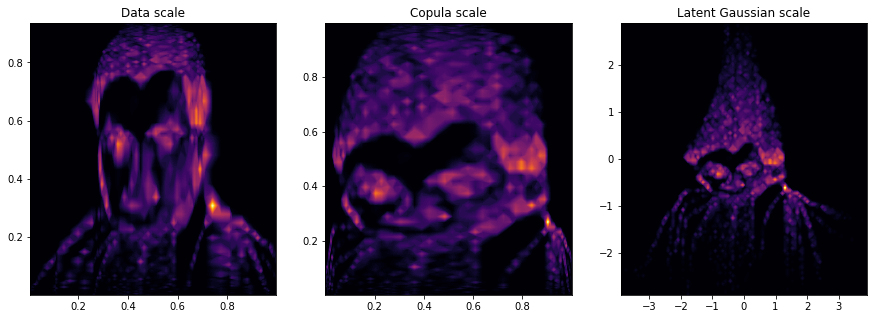

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

# Assuming X, Y, Z are already defined
# X, Y = np.meshgrid(np.linspace(-2.9, 2.9, 100), np.linspace(-2.9, 2.9, 100))
# Z = some_function_to_compute_Z(X, Y)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots in a row

# First subplot - data scale
in_1 = np.clip(scs.norm.cdf(X), a_max=0.999, a_min=0.001)
in_2 = np.clip(scs.norm.cdf(Y), a_max=0.999, a_min=0.001)
ax[0].contourf(inverted_cdf1(in_1), inverted_cdf2(in_2), Z, levels=100, cmap='inferno')
ax[0].set_title('Data scale')

# Second subplot - Copula scale
ax[1].contourf(scs.norm.cdf(X), scs.norm.cdf(Y), Z, levels=100, cmap='inferno')
ax[1].set_title('Copula scale')

# Third subplot - Latent Gaussian scale
ax[2].contourf(X, Y, Z, levels=100, cmap='inferno')
ax[2].set_title('Latent Gaussian scale')

plt.show()